In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,target)

X_train shape: (810, 54)
X_test shape: (100, 54)
X_val shape: (90, 54)
y_train shape: (810,)
y_test shape: (100,)
y_val shape: (90,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_hbg = HistGradientBoostingClassifier()
model_hbg.fit(X_dev, y_dev)
predsDevhbg = model_hbg.predict(X_dev)
predsTesthbg = model_hbg.predict(X_test)

In [5]:
testhbg_score =  accuracy_score(y_test, predsTesthbg)
devhbg_score = accuracy_score(y_dev, predsDevhbg)

In [6]:
print("Classification Score for HistGradientBoosting Classifier on Dev dataset:\n")
print("Dev Score : ", devhbg_score)
print(classification_report(y_dev, predsDevhbg))
print("--------------------------------------------------------")
print("Classification Score for HistGradientBoosting Classifier on Test dataset:\n")
print("Test Score :", testhbg_score)
print(classification_report(y_test, predsTesthbg))

Classification Score for HistGradientBoosting Classifier on Dev dataset:

Dev Score :  0.9988888888888889
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        92
   classical       1.00      1.00      1.00        92
     country       1.00      1.00      1.00        92
       disco       1.00      1.00      1.00        92
      hiphop       1.00      1.00      1.00        93
        jazz       1.00      1.00      1.00        83
       metal       1.00      0.99      0.99        92
         pop       1.00      1.00      1.00        92
      reggae       1.00      1.00      1.00        86
        rock       0.99      1.00      0.99        86

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

--------------------------------------------------------
Classification Score for HistGradientBoosting Classifier on Test dataset:

Tes

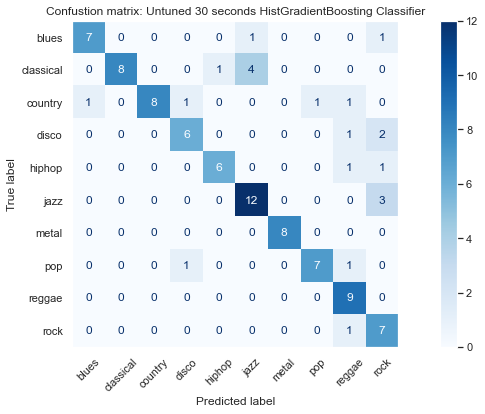

Accuracy : 0.78
Macro F-1 Score : 0.79


In [7]:
# Evaluate Model on Test set
class_labels = list(model_hbg.classes_)
macro_f1, accuracy = evaluate_model(predsTesthbg, y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds HistGradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [8]:
parameters = {"max_iter": np.linspace(100,300,2,dtype=int),
             "learning_rate": [0.1,0.001,0.01],
             "max_depth": random.sample(range(3, 30),3)}
print(parameters)

{'max_iter': array([100, 300]), 'learning_rate': [0.1, 0.001, 0.01], 'max_depth': [7, 21, 29]}


In [9]:
tune_hbg = GridSearchCV(estimator = model_hbg, param_grid = parameters, cv = 5)
tune_hbg.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.001, 0.01],
                         'max_depth': [7, 21, 29],
                         'max_iter': array([100, 300])})

In [10]:
print("Best Score :", tune_hbg.best_score_)
print("Best Parameters :",tune_hbg.best_params_)

Best Score : 0.7233333333333334
Best Parameters : {'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 300}


In [11]:
predsDevhbg_tuned = tune_hbg.predict(X_dev)
predsTesthbg_tuned = tune_hbg.predict(X_test)

print("Score on Dev data for HBG using GridSearchCV:", accuracy_score(y_dev, predsDevhbg_tuned))
print("Score on Test data for HBG using GridSearchCV:",accuracy_score(y_test, predsTesthbg_tuned))

Score on Dev data for HBG using GridSearchCV: 0.9988888888888889
Score on Test data for HBG using GridSearchCV: 0.78


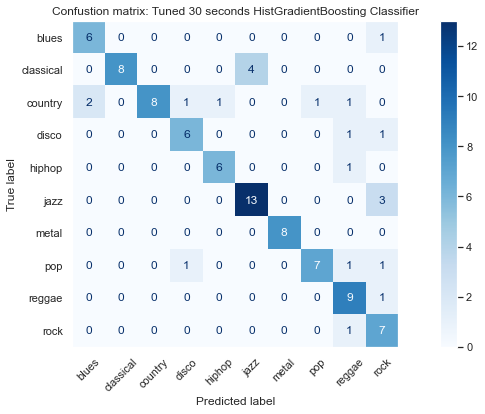

Accuracy : 0.78
Macro F-1 Score : 0.79


In [12]:
# Evaluate Model on Test set
class_labels = list(model_hbg.classes_)
macro_f1, accuracy = evaluate_model(predsTesthbg_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds HistGradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [13]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27462107 0.16378828 0.106374   0.0723295  0.05484226 0.0387792
 0.02690359 0.02395643 0.02175637 0.01846612 0.01427943 0.01395746
 0.0120279  0.01112264 0.01017838 0.00968102 0.00884286 0.00796854
 0.00769754 0.00724503 0.00710406 0.0065521  0.00600103 0.00568844
 0.00541248 0.00495716 0.00484606 0.0046887  0.00451327 0.00420588]
Sum of Explained Variance: 0.9526384961052763


In [14]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.000578,-0.630373,-0.054837,0.410234,0.009388,0.027373,-0.032693,-0.147327,0.031381,0.111807,...,0.076359,0.102671,-0.078515,0.038777,-0.006710,-0.020248,0.122581,0.059799,0.035578,classical
1,0.071451,-0.402465,-0.106785,0.332658,-0.060422,0.226589,0.122803,-0.066843,0.069256,-0.088956,...,0.119519,0.093006,-0.017433,0.096459,0.007292,-0.108814,-0.025943,-0.007280,0.001028,jazz
2,-0.047268,0.326820,-0.598692,0.227380,0.045610,0.264122,-0.077906,0.063580,-0.168399,0.038900,...,-0.088405,0.045638,-0.057271,-0.031956,0.010596,0.089807,-0.025416,0.155727,-0.050312,country
3,-0.437642,0.235405,-0.003960,0.029110,-0.170677,-0.094826,-0.142893,0.105725,0.099775,-0.181441,...,0.021402,-0.013820,0.027506,0.055196,0.133483,0.102584,0.088352,0.037717,0.066517,metal
4,-0.849344,0.103658,-0.048105,-0.018132,-0.023246,-0.159358,0.035768,-0.071899,0.111845,0.102860,...,0.041386,-0.010278,0.015446,-0.029090,0.038961,0.012031,-0.040542,-0.010834,0.018305,disco


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [15]:
model_pca = HistGradientBoostingClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainhbg = model_pca.predict(pca_data)
pcaTesthbg = model_pca.predict(pca_data_test)

In [16]:
pcatesthbg_score =  accuracy_score(y_test, pcaTesthbg)
pcahbg_score = accuracy_score(y_dev, pcaTrainhbg)

In [17]:
print("Classification Score for HistGradientBoosting Classifier on Train dataset:\n")
print("Train Score : ", pcahbg_score)
print("--------------------------------------------------------")
print("Classification Score for HistGradientBoosting Classifier on Test dataset:\n")
print("Test Score :", pcatesthbg_score)

Classification Score for HistGradientBoosting Classifier on Train dataset:

Train Score :  0.9988888888888889
--------------------------------------------------------
Classification Score for HistGradientBoosting Classifier on Test dataset:

Test Score : 0.73


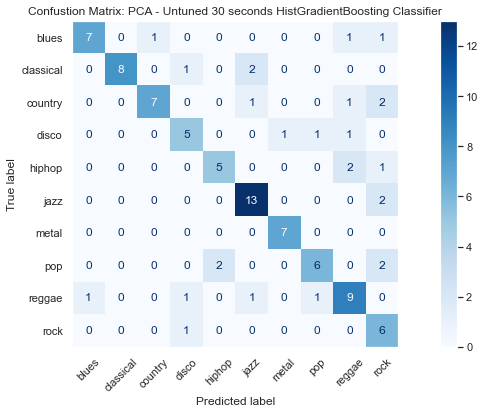

Accuracy : 0.73
Macro F-1 Score : 0.73


In [18]:
# Evaluate Model
class_labels = list(model_hbg.classes_)
macro_f1, accuracy = evaluate_model(pcaTesthbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds HistGradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [19]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000578,-0.630373,-0.054837,0.410234,0.009388,0.027373,-0.032693,-0.147327,0.031381,0.111807,...,-0.184617,0.076359,0.102671,-0.078515,0.038777,-0.006710,-0.020248,0.122581,0.059799,0.035578
1,0.071451,-0.402465,-0.106785,0.332658,-0.060422,0.226589,0.122803,-0.066843,0.069256,-0.088956,...,0.119453,0.119519,0.093006,-0.017433,0.096459,0.007292,-0.108814,-0.025943,-0.007280,0.001028
2,-0.047268,0.326820,-0.598692,0.227380,0.045610,0.264122,-0.077906,0.063580,-0.168399,0.038900,...,-0.008485,-0.088405,0.045638,-0.057271,-0.031956,0.010596,0.089807,-0.025416,0.155727,-0.050312
3,-0.437642,0.235405,-0.003960,0.029110,-0.170677,-0.094826,-0.142893,0.105725,0.099775,-0.181441,...,-0.128740,0.021402,-0.013820,0.027506,0.055196,0.133483,0.102584,0.088352,0.037717,0.066517
4,-0.849344,0.103658,-0.048105,-0.018132,-0.023246,-0.159358,0.035768,-0.071899,0.111845,0.102860,...,-0.059810,0.041386,-0.010278,0.015446,-0.029090,0.038961,0.012031,-0.040542,-0.010834,0.018305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-0.654431,0.218151,0.332880,0.090825,0.133881,-0.215552,0.054109,0.024756,0.233050,-0.024788,...,0.274417,-0.020315,0.088904,-0.032886,-0.049048,-0.005416,-0.086059,-0.006122,-0.001027,0.012573
896,0.515280,-0.634698,0.082394,0.485203,-0.101831,-0.139826,-0.145431,0.177589,0.022338,0.179446,...,0.034652,-0.016839,-0.006853,-0.115303,-0.065851,-0.188365,-0.013339,-0.003464,-0.056189,-0.032756
897,0.976786,0.902560,0.595924,0.289103,0.483065,0.202644,0.115374,0.003242,-0.108638,-0.320622,...,0.044738,0.006509,-0.010589,-0.013318,-0.031546,-0.128555,-0.033763,-0.000507,0.074961,0.054689
898,0.124804,0.297352,-0.452053,-0.032074,0.037626,0.157139,-0.016185,-0.012226,-0.084179,0.132881,...,0.118697,-0.045338,0.004519,0.033043,0.039414,-0.129773,0.086253,0.036733,0.035836,-0.079134


In [20]:
model_pca_tuned = tune_hbg
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainhbg_tuned = model_pca_tuned.predict(pca_data)
pcaTesthbg_tuned = model_pca_tuned.predict(pca_data_test)

In [21]:
pcatesthbg_score =  accuracy_score(y_test, pcaTesthbg_tuned)
pcahbg_score = accuracy_score(y_dev, pcaTrainhbg_tuned)

In [22]:
print("Classification Score for HistGradientBoosting Classifier on Train dataset:\n")
print("Train Score : ", pcahbg_score)
print("--------------------------------------------------------")
print("Classification Score for HistGradientBoosting Classifier on Test dataset:\n")
print("Test Score :", pcatesthbg_score)

Classification Score for HistGradientBoosting Classifier on Train dataset:

Train Score :  0.9988888888888889
--------------------------------------------------------
Classification Score for HistGradientBoosting Classifier on Test dataset:

Test Score : 0.73


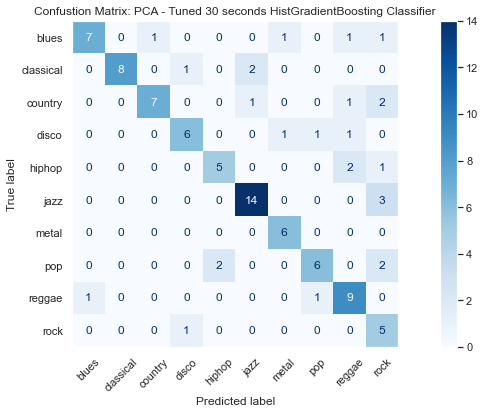

Accuracy : 0.73
Macro F-1 Score : 0.73


In [23]:
# Evaluate Model
class_labels = list(model_hbg.classes_)
macro_f1, accuracy = evaluate_model(pcaTesthbg_tuned, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds HistGradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)